In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer, execute
from qiskit.visualization import plot_histogram

In [2]:
svbackend = BasicAer.get_backend('statevector_simulator')
qmbackend = BasicAer.get_backend('qasm_simulator')

# Shor's Algorithm

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import math
from fractions import Fraction
np.set_printoptions(precision=3, suppress=True)

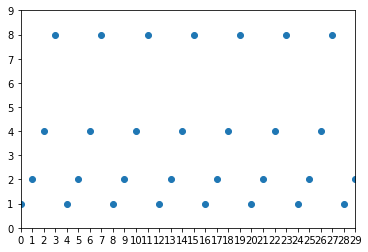

In [64]:
N = 15
a = 2
Q = 30
xlist = np.array(list(range(Q)))
ylist = np.array([(a**x)%N for x in xlist])
plt.scatter(xlist,ylist)
plt.xlim(0,max(xlist))
plt.ylim(0,max(ylist)+1)
plt.xticks(xlist)
plt.show()
for i in range(1,Q):
    if ylist[i] == 1:
        s = i
        break

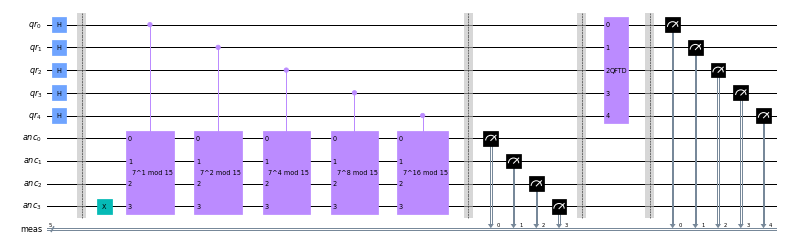

In [51]:
#Works for a^x mod 15

N = 15
#nqr = math.ceil(math.log(N*N,2))
nqr = math.ceil(math.log(2*N-1,2))
nanc = math.ceil(math.log(N,2))
a = 7
Q = 2**nqr

qr = QuantumRegister(nqr, 'qr')
anc = QuantumRegister(nanc, 'anc')
meas = ClassicalRegister(nqr, 'meas')
shor = QuantumCircuit(qr, anc, meas)
shor.h(qr)
shor.barrier()

##################################################################################################################

shor.x(anc[nanc-1])
def amod15(a, exp):
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")    
    else:
        qc = QuantumCircuit(4)    
        for i in range(exp):
            if a in [2,13]:
                qc.swap(0,1)
                qc.swap(1,2)
                qc.swap(2,3)
            if a in [7,8]:
                qc.swap(2,3)
                qc.swap(1,2)
                qc.swap(0,1)
            if a in [4, 11]:
                qc.swap(1,3)
                qc.swap(0,2)
            if a in [7,11,13]:
                for q in range(4):
                    qc.x(q)
    return qc

def c_amod15(a, exp):
    qc = amod15(a,exp).to_gate()
    qc.name = "%i^%i mod 15" % (a, exp)
    c_qc = qc.control()
    return c_qc

if N == 15:
    for nq in range(nqr):
        shor.append(c_amod15(a, 2**nq), [qr[nq]]+[qanc for qanc in anc])
else:
    raise ValueError("Currently N is only 15")
    
##################################################################################################################

shor.barrier()
shor.measure(anc,meas[:nanc])
shor.barrier()

##################################################################################################################

def qdft(n):
    qc = QuantumCircuit(n)
    for q in range(n//2):
        qc.swap(q, n-q-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    return qc

def qdftd(n):
    qc = qdft(n).inverse().to_gate()
    qc.name = "QFTD" 
    return qc

shor.append(qdftd(nqr), qr)

##################################################################################################################

shor.barrier()
shor.measure(qr,meas)
shor.draw(output='mpl', fold=-1, scale=0.5)

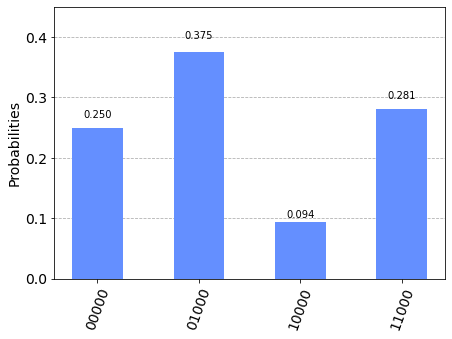

In [52]:
job = execute(shor, qmbackend, shots=Q)
result = job.result()
result.get_counts()
plot_histogram(result.get_counts())

In [65]:
print("Expected peak deltas [Cheating]:")
print([(Q/s)*i for i in range(s)])

print("\nObserved peak deltas:")
values = [int(output,2) for output in result.get_counts()]
print(values)

print("\nPunctued deltas:")
values = [int(output,2)/Q for output in result.get_counts()]
print(values)

print("\nDenominators")
values = [Fraction(int(output,2)/Q).limit_denominator(15).denominator for output in result.get_counts()]
print(values)

print("\nResult:")
if s == math.lcm(*values):
    print("Success")
    print(s)
else:
    print("Failure")
    print(math.lcm(*values))

Expected peak deltas [Cheating]:
[0.0, 7.5, 15.0, 22.5]

Observed peak deltas:
[8, 16, 0, 24]

Punctued deltas:
[0.26666666666666666, 0.5333333333333333, 0.0, 0.8]

Denominators
[15, 15, 1, 5]

Result:
Failure
15
